In [1]:
import sys, os, pickle, time, json, yaml, re
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
import numpy as np
import pandas as pd
import scipy as sp
import root_numpy as rtnp
from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from collections import Counter
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from scipy.stats import chi2 as scipy_chi2
from histo_utilities import create_TH1D, make_ratio_plot, create_TH2D, std_color_list, rootTH1_to_np

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1


CMS_lumi.extraText = 6*' ' + 'Simulation Internal'

In [3]:
candDir='ntuples_B2DstMu_220209'
skimmedTag=''
MCsample = {
######## Signals
'tau': DSetLoader('Bd_TauNuDst', candDir=candDir, skimmedTag=skimmedTag),
'mu': DSetLoader('Bd_MuNuDst', candDir=candDir, skimmedTag=skimmedTag),
}

In [5]:
category = 'High'

In [6]:
df = {}
df['mu'] = pd.DataFrame(rtnp.root2array(MCsample['mu'].skimmed_dir + '/'+category+'_bare.root'))

try:
    weights = pd.DataFrame(rtnp.root2array(
        MCsample['mu'].skimmed_dir + '/weights/'+category+'_bare_test_'+category.lower()+'_CLN_blinded.root'
    ))
    df['mu']['w'] = weights['central']
except:
    print 'Falling back to applying only pu weights'
    from pileup_utilities import pileupReweighter
    from categoriesDef import categories as categoriesDef
    
    skimmedFile_loc = MCsample['mu'].skimmed_dir + '/{}_{}.root'.format(category, 'bare')
    puReweighter = pileupReweighter(skimmedFile_loc, 'hAllNTrueIntMC', trg=categoriesDef[category.lower()].trg)
    df['mu']['w'] = puReweighter.getPileupWeights(df['mu']['MC_nInteractions'])

dataLoc = '/storage/af/group/rdst_analysis/BPhysics/data/cmsRD/'
df['data'] = pd.DataFrame(rtnp.root2array(
    dataLoc+'skimmed/B2DstMu_220209_'+category+'_corr.root'))

In [7]:
binning = {}
binning['q2'] = [0, 3.5, 6, 9.4, 12]

negSide = [-2.5, -1.5, -1.0, -0.6, -0.4, -0.2]
binning['M2_miss'] = [
    negSide + [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 1.5, 4],
    negSide + [0.0, 0.1, 0.2, 0.3] + list(np.arange(0.4, 3.5, 0.2)) + [8],
    negSide + list(np.arange(0, 6, 0.2)) + [8],
    negSide + list(np.arange(0, 7.8, 0.2)) + [8],
]

In [8]:
# Create centered values
for n in ['mu', 'data']:
    for a in ['x', 'y']:
        df[n]['vtxC_'+a] = 1e4*(df[n]['vtx_PV_'+a] - np.mean(df[n]['vtx_PV_'+a]))
        print n, a, np.mean(df[n]['vtx_PV_'+a])

mu x 0.0107641314752
mu y 0.0417446408542
data x 0.0963835704338
data y -0.0615212042489


In [10]:
0.0107641314752 -  100e-4

0.0007641314752000004

# Draw plots

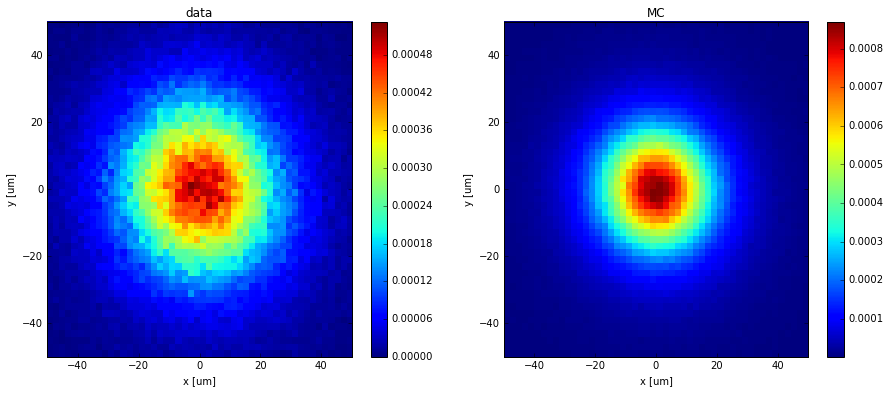

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

bounds = ((-50, 50), (-50, 50))
h = axs[0].hist2d(df['data']['vtxC_x'], df['data']['vtxC_y'], range=bounds, bins=50, normed=True)
axs[0].set_title('data')
fig.colorbar(h[3], ax=axs[0])
h = axs[1].hist2d(df['mu']['vtxC_x'], df['mu']['vtxC_y'], range=bounds, bins=50, normed=True, weights=df['mu']['w'])
axs[1].set_title('MC')
fig.colorbar(h[3], ax=axs[1])
for ax in axs:
    ax.set_xlabel('x [um]')
    ax.set_ylabel('y [um]')

In [9]:
def doubleCrystalball(x, mu, sigma, beta, m):
    left = sp.stats.crystalball.pdf(x-mu, beta, m, loc=0, scale=sigma)
    right = sp.stats.crystalball.pdf(mu-x, beta, m, loc=0, scale=sigma)
    return np.where(x < m, left, right)

In [10]:
def getBeamSpotWeights(ds, axis, parNew, parOld):
    x = 1e4*(ds['vtx_PV_'+axis] - np.mean(ds['vtx_PV_'+axis]))
    return doubleCrystalball(x, *parNew)/doubleCrystalball(x, *parOld)

In [11]:
def getBeamSpotCorrectionWeights(ds, param, dmu_x=0, dmu_y=0):
    mu, sigma, beta, m = param['x']['data']
    mu += dmu_x
    out = getBeamSpotWeights(ds, 'x', [mu, sigma, beta, m], param['x']['MC'])
    
    mu, sigma, beta, m = param['y']['data']
    mu += dmu_y
    out *= getBeamSpotWeights(ds, 'y', [mu, sigma, beta, m], param['y']['MC'])
    return out

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


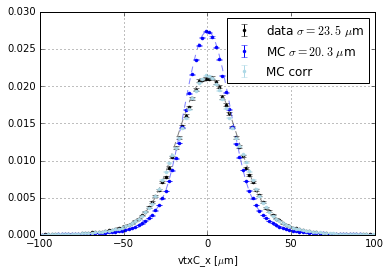

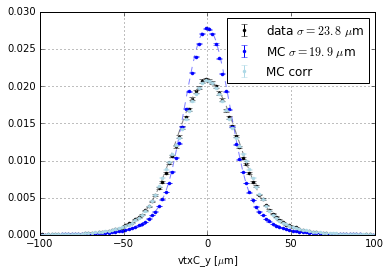

In [12]:
param = {}
for n in ['vtxC_x', 'vtxC_y']:
    plt.figure()
    h = create_TH1D(df['data'][n], binning=[100, -100, 100], scale_histo='norm', widthNorm=True)
    r = rootTH1_to_np(h)
    sData = np.std(df['data'][n])
    parData, cov = sp.optimize.curve_fit(doubleCrystalball, r[:,0], r[:,1], p0=[0, 0.8*sData, 1.5, 1.5], sigma=r[:,2])
    h = plt.errorbar(r[:,0], r[:,1], yerr=r[:,2], fmt='.', color='k', label=r'data $\sigma={:.1f}\ \mu$m'.format(sData))
    plt.plot(r[:,0], doubleCrystalball(r[:,0], *parData), color='gray', ls='--')

    h = create_TH1D(df['mu'][n], binning=[100, -100, 100], weights=df['mu']['w'], scale_histo='norm', widthNorm=True)
    r = rootTH1_to_np(h)
    sMC = np.std(df['mu'][n])
    parMC, cov = sp.optimize.curve_fit(doubleCrystalball, r[:,0], r[:,1], p0=[0, 0.8*sMC, 1.5, 1.5], sigma=r[:,2])
    h = plt.errorbar(r[:,0], r[:,1], yerr=r[:,2], fmt='.', color='blue', label=r'MC $\sigma={:.1f}\ \mu$m'.format(sMC))
    plt.plot(r[:,0], doubleCrystalball(r[:,0], *parMC), color='blue', alpha=0.5, ls='--')

    widthCorr = getBeamSpotWeights(df['mu'], n[-1], parData, parMC)
    h = create_TH1D(df['mu'][n], binning=[100, -100, 100], weights=df['mu']['w']*widthCorr, scale_histo='norm', widthNorm=True)
    r = rootTH1_to_np(h)
    plt.errorbar(r[:,0], r[:,1], yerr=r[:,2], fmt='.', label='MC corr', color='lightblue')

    plt.legend(loc='best', numpoints=1)
    plt.xlabel(n + r' [$\mu$m]')
    plt.grid()
    
    param[n[-1]] = {'data':parData, 'MC': parMC}

In [13]:
param

{'x': {'MC': array([1.04197141e-02, 1.40629548e+01, 1.53228125e+00, 6.12027684e+00]),
  'data': array([ 0.0472086 , 18.32630809,  1.60504137,  9.28954747])},
 'y': {'MC': array([-0.03264142, 13.80059759,  1.53490477,  6.01098082]),
  'data': array([ 0.04382902, 18.94746942,  1.64948481, 10.15586385])}}

In [14]:
out = {}
for k in param.keys():
    out[k] = {}
    for kk in param[k].keys():
        out[k][kk] = [float(x) for x in param[k][kk]]
from datetime import datetime
fname = '/storage/af/group/rdst_analysis/BPhysics/data/calibration/beamSpot/crystalball_calibration_v0_'+category+'.yaml'
with open(fname, 'w') as f:
    f.write('# Calibration of beam spot using independent CB approx\n')
    f.write('# pars = [mu, sigma, beta, m]\n')
    f.write('# '+datetime.now().strftime('%Y-%m-%d %H:%M:%S') + '\n')
    f.write(yaml.dump(out))
    
param = yaml.load(open(fname, 'r'))

In [15]:
print param

{'y': {'data': [0.04382902423958379, 18.94746942465676, 1.6494848116617087, 10.15586385382515], 'MC': [-0.03264142387421513, 13.800597594434835, 1.5349047737820123, 6.010980821675457]}, 'x': {'data': [0.04720860189516087, 18.326308086876033, 1.605041369475455, 9.289547469179073], 'MC': [0.010419714057732671, 14.062954832399118, 1.5322812512379278, 6.120276835561126]}}


In [16]:
df['mu']['w_width'] = getBeamSpotCorrectionWeights(df['mu'], param)

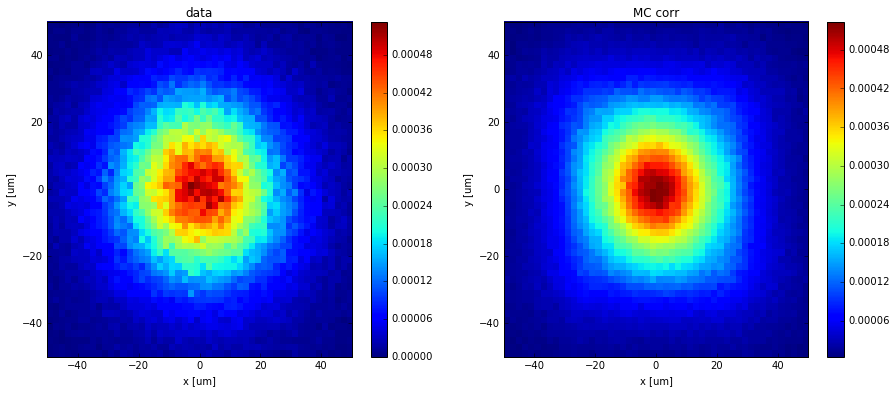

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

bounds = ((-50, 50), (-50, 50))
h = axs[0].hist2d(df['data']['vtxC_x'], df['data']['vtxC_y'], range=bounds, bins=50, normed=True)
fig.colorbar(h[3], ax=axs[0])
h = axs[1].hist2d(df['mu']['vtxC_x'], df['mu']['vtxC_y'], range=bounds, bins=50, normed=True, 
                  weights=df['mu']['w']*df['mu']['w_width'])
fig.colorbar(h[3], ax=axs[1])
axs[0].set_title('data')
axs[1].set_title('MC corr')
for ax in axs:
    ax.set_xlabel('x [um]')
    ax.set_ylabel('y [um]')

# Check effect on missing mass

In [18]:
sel = df['mu']['q2'] < binning['q2'][1]
auxDf = df['mu'][sel]

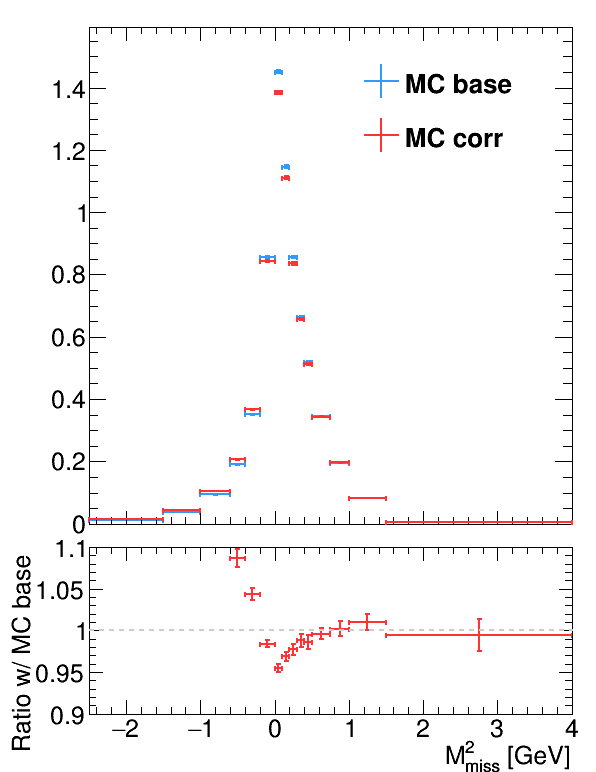

In [19]:
h_base = create_TH1D(auxDf['M2_miss'], 'MC base', weights=auxDf['w'], 
                     color=0, binning=np.array(binning['M2_miss'][0]), widthNorm=True, scale_histo='norm')

h_corr = create_TH1D(auxDf['M2_miss'][sel], 'MC corr', weights=auxDf['w']*auxDf['w_width'],
                     color=1, binning=np.array(binning['M2_miss'][0]), widthNorm=True, scale_histo='norm')


h_base.SetXTitle('M^{2}_{miss} [GeV]')
c = make_ratio_plot([h_base, h_corr], ratio_bounds=[0.9, 1.1], 
                    leg_pos=[0.6, 0.7, 0.92, 0.9])
c.Draw()
donotdelete.append(c)

Warning in <TROOT::Append>: Replacing existing TH1: MC corr (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio


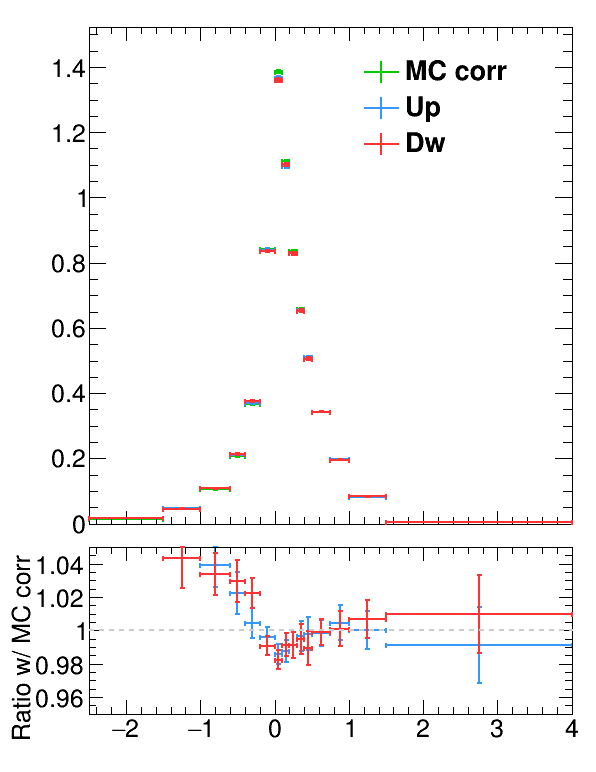

In [20]:
r = 10
phi = 45 + 90
dx = r*np.cos(np.deg2rad(phi))
dy = r*np.sin(np.deg2rad(phi))

auxW = getBeamSpotCorrectionWeights(auxDf, param, dmu_x=-dx, dmu_y=-dy)
h_xDw = create_TH1D(auxDf['M2_miss'][sel], 'Up', weights=auxDf['w']*auxW,
                    color=0, binning=np.array(binning['M2_miss'][0]), widthNorm=True, scale_histo='norm')

auxW = getBeamSpotCorrectionWeights(auxDf, param, dmu_x=dx, dmu_y=dy)
h_xUp = create_TH1D(auxDf['M2_miss'][sel], 'Dw', weights=auxDf['w']*auxW,
                    color=1, binning=np.array(binning['M2_miss'][0]), widthNorm=True, scale_histo='norm')


h_corr = create_TH1D(auxDf['M2_miss'][sel], 'MC corr', weights=auxDf['w']*auxDf['w_width'],
                     color=2, binning=np.array(binning['M2_miss'][0]), widthNorm=True, scale_histo='norm')


h_base.SetXTitle('M^{2}_{miss} [GeV]')
c = make_ratio_plot([h_corr, h_xDw, h_xUp], ratio_bounds=[0.95, 1.05], 
                    leg_pos=[0.6, 0.7, 0.92, 0.9])
c.Draw()
donotdelete.append(c)

In [21]:
# auxDf['vtx_PV_r'] = np.hypot(auxDf['vtx_PV_x'], auxDf['vtx_PV_y'])

# plt.hist(1e4*auxDf['vtx_PV_r'], bins=50, range=(1000,1300), normed=True)
# plt.xlabel('PV radius [um]');
# plt.ylabel('Events');

# rLow, rHigh = np.percentile(auxDf['vtx_PV_r'], [20, 80])
# y = list(plt.ylim())
# plt.plot(2*[1e4*rLow], y, 'r--')
# plt.plot(2*[1e4*rHigh], y, 'r--')

In [22]:
# h_base = create_TH1D(auxDf['M2_miss'], 'h_base', color=0,
#          binning=np.array(binning['M2_miss'][0]), widthNorm=True, scale_histo='norm')

# sel = auxDf['vtx_PV_r'] < rLow
# h_rLow = create_TH1D(auxDf['M2_miss'][sel], 'h_rLow', color=1,
#          binning=np.array(binning['M2_miss'][0]), widthNorm=True, scale_histo='norm')

# sel = auxDf['vtx_PV_r'] < rHigh
# h_rHig = create_TH1D(auxDf['M2_miss'][sel], 'h_rHigh', color=2,
#          binning=np.array(binning['M2_miss'][0]), widthNorm=True, scale_histo='norm')

# h_base.SetXTitle('M^{2}_{miss} [GeV]')
# c = make_ratio_plot([h_base, h_rLow, h_rHig], ratio_bounds=[0.9, 1.1], 
#                     leg_pos=[0.6, 0.7, 0.92, 0.9])
# c.Draw()
# donotdelete.append(c)